Rebecca Mizrahi (260975001), Amélie Barsoum (290988658), Samantha Handal (260983914)

# **Assignment 3: Classification of Image Data**

## Task 1: Acquire the data

In [1]:
!pip install pandas

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/COMP551/assignment_3/archive/'

Mounted at /content/drive


In [2]:
train_data_path = path + 'sign_mnist_train/sign_mnist_train.csv'
test_data_path = path + 'sign_mnist_test/sign_mnist_test.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

X_train = train_data.drop('label', axis=1).values
y_train = train_data['label'].values
X_test = test_data.drop('label', axis=1).values
y_test = test_data['label'].values

# Normalize and flatten
X_train_normalized = X_train / 255.0
X_test_normalized = X_test / 255.0
X_train_flattened = X_train_normalized.reshape(X_train_normalized.shape[0], -1)
X_test_flattened = X_test_normalized.reshape(X_test_normalized.shape[0], -1)

# One-hot encode labels + function to map labels to a continuous range
def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y]

def map_labels_to_continuous_range(y):
    unique_labels = np.unique(y)
    label_to_continuous = {label: i for i, label in enumerate(unique_labels)}
    return np.array([label_to_continuous[label] for label in y])

# Map labels using function
y_train_mapped = map_labels_to_continuous_range(y_train)
y_test_mapped = map_labels_to_continuous_range(y_test)

# Calculate the # of classes
num_classes_mapped = len(np.unique(y_train_mapped))

# Perform one-hot encoding with the correctly mapped labels
y_train_encoded = np.eye(num_classes_mapped)[y_train_mapped]
y_test_encoded = np.eye(num_classes_mapped)[y_test_mapped]

X_train.shape

(27455, 784)

## Task 2: Implement an MLP to classify image data

In [3]:
# Define some functions we will use

def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

def compute_loss(y_true, y_pred):
    m = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-9)) / m

def relu_derivative(x):
    return (x > 0).astype(float)

In [4]:
class MLP:
    def __init__(self, input_dim, hidden_dims, output_dim):
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim

        # Init weights and biases
        layers = [input_dim] + hidden_dims + [output_dim]
        self.weights = [np.random.randn(prev, next) * 0.1 for prev, next in zip(layers[:-1], layers[1:])]
        self.biases = [np.zeros((1, size)) for size in layers[1:]]

    def forward(self, X):
        self.activations = [X]
        self.Zs = []

        for W, b in zip(self.weights[:-1], self.biases[:-1]):
            Z = np.dot(self.activations[-1], W) + b
            A = relu(Z)
            self.Zs.append(Z)
            self.activations.append(A)

        Z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        A = softmax(Z)
        self.Zs.append(Z)
        self.activations.append(A)

        return A

    def backward(self, X, y):
        m = y.shape[0]
        self.dWs = []
        self.dBs = []
        output_error = self.activations[-1] - y  # For the output layer

        for i in reversed(range(len(self.weights))):
            dW = np.dot(self.activations[i].T, output_error) / m
            dB = np.sum(output_error, axis=0, keepdims=True) / m
            self.dWs.insert(0, dW)
            self.dBs.insert(0, dB)

            if i > 0:  # Skip the input layer (no weights/biases)
                output_error = np.dot(output_error, self.weights[i].T) * relu_derivative(self.Zs[i-1])


    def update_parameters(self, learning_rate):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * self.dWs[i]
            self.biases[i] -= learning_rate * self.dBs[i]
        self.dWs = []  # Clear gradients after update
        self.dBs = []


    def fit(self, X, y, epochs, learning_rate, batch_size):
        for epoch in range(epochs):
            for i in range(0, X.shape[0], batch_size):
                end = i + batch_size
                batch_X, batch_y = X[i:end], y[i:end]
                self.forward(batch_X)
                self.backward(batch_X, batch_y)
                self.update_parameters(learning_rate)

            if epoch % 10 == 0:
                loss = compute_loss(y, self.forward(X))
                print(f"Epoch {epoch}, Loss: {loss}")

    def predict(self, X):
        probabilities = self.forward(X)
        return np.argmax(probabilities, axis=1)

    def check_gradients(self, X, y, epsilon=1e-7, layer_idx=0):
        original_weights = self.weights[layer_idx].copy()
        num_grads = np.zeros_like(original_weights)
        self.forward(X)
        self.backward(X, y)
        analytical_grads = self.dWs[layer_idx]

        for i in range(original_weights.shape[0]):
            for j in range(original_weights.shape[1]):
                # Perturb weight
                self.weights[layer_idx][i, j] += epsilon
                loss_plus_epsilon = compute_loss(y, self.forward(X))
                self.weights[layer_idx][i, j] -= 2 * epsilon
                loss_minus_epsilon = compute_loss(y, self.forward(X))
                # Restore weight
                self.weights[layer_idx][i, j] = original_weights[i, j]
                # Compute num gradient
                num_grads[i, j] = (loss_plus_epsilon - loss_minus_epsilon) / (2 * epsilon)

        self.weights[layer_idx] = original_weights

        # Calc error
        numerator = np.linalg.norm(analytical_grads - num_grads)
        denominator = np.linalg.norm(analytical_grads) + np.linalg.norm(num_grads)
        relative_error = numerator / denominator

        print(f"Gradient Check Relative Error for layer {layer_idx}: {relative_error}")
        return relative_error

def evaluate_acc(y_true_one_hot, y_pred_indices):

    y_true_indices = np.argmax(y_true_one_hot, axis=1)

    # Compare indices to calc accuracy
    correct_predictions = (y_true_indices == y_pred_indices)
    accuracy = np.mean(correct_predictions)
    return accuracy


mlp = MLP(input_dim=X_train_flattened.shape[1], hidden_dims=[64, 64], output_dim=num_classes_mapped)
X_small = X_train_flattened[:10]
y_small = y_train_encoded[:10]
mlp.check_gradients(X_small, y_small)
mlp.fit(X_train_flattened, y_train_encoded, epochs=100, learning_rate=0.01, batch_size=32)

# Evaluate accuracy of predictions
predictions = mlp.predict(X_test_flattened)
accuracy = evaluate_acc(y_test_encoded, predictions)
print(f"Test accuracy: {accuracy}")

Gradient Check Relative Error for layer 0: 9.594975273591625e-08
Epoch 0, Loss: 2.617370703976207
Epoch 10, Loss: 0.4765017348968351
Epoch 20, Loss: 0.12352361885257482
Epoch 30, Loss: 0.035715768820156805
Epoch 40, Loss: 0.016409372860954993
Epoch 50, Loss: 0.010363225091901093
Epoch 60, Loss: 0.0074065009928780895
Epoch 70, Loss: 0.005676389951693058
Epoch 80, Loss: 0.004544023403295556
Epoch 90, Loss: 0.0037625321342400027
Test accuracy: 0.695064138315672


## Task 3: Run the experiments and report

In [5]:
# More functions we will use

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha * x, x)

def leaky_relu_derivative(x, alpha=0.01):
    dx = np.ones_like(x)
    dx[x < 0] = alpha
    return dx

### 1. Create three different models: (1) an MLP with no hidden layer, i.e., it directly maps the inputs to outputs, (2) an MLP with a single hidden layer having ReLU activations, (3) an MLP with 2 hidden layers having ReLU activations

In [6]:
class MLP:
    def __init__(self, input_dim, hidden_dims, output_dim, use_hidden_layers=True):
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims if use_hidden_layers else []
        self.output_dim = output_dim

        # Init weights and biases
        layers = [input_dim] + self.hidden_dims + [output_dim]
        self.weights = [np.random.randn(prev, next) * 0.1 for prev, next in zip(layers[:-1], layers[1:])]
        self.biases = [np.zeros((1, size)) for size in layers[1:]]

    def forward(self, X):
        self.activations = [X]
        self.Zs = []

        for W, b in zip(self.weights[:-1], self.biases[:-1]):
            Z = np.dot(self.activations[-1], W) + b
            A = relu(Z)
            self.Zs.append(Z)
            self.activations.append(A)

        Z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        A = softmax(Z)
        self.Zs.append(Z)
        self.activations.append(A)

        return A

    def backward(self, X, y):
        m = y.shape[0]
        self.dWs = []
        self.dBs = []
        output_error = self.activations[-1] - y

        for i in reversed(range(len(self.weights))):
            dW = np.dot(self.activations[i].T, output_error) / m
            dB = np.sum(output_error, axis=0, keepdims=True) / m
            self.dWs.insert(0, dW)
            self.dBs.insert(0, dB)

            if i > 0:
                output_error = np.dot(output_error, self.weights[i].T) * relu_derivative(self.Zs[i-1])


    def update_parameters(self, learning_rate):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * self.dWs[i]
            self.biases[i] -= learning_rate * self.dBs[i]
        self.dWs = []  #
        self.dBs = []


    def fit(self, X, y, epochs, learning_rate, batch_size):
        self.training_losses = []
        self.training_accuracies = []

        for epoch in range(epochs):
            for i in range(0, X.shape[0], batch_size):
                end = i + batch_size
                batch_X, batch_y = X[i:end], y[i:end]
                self.forward(batch_X)
                self.backward(batch_X, batch_y)
                self.update_parameters(learning_rate)

            loss = compute_loss(y, self.forward(X))
            accuracy = evaluate_acc(y, self.predict(X))
            self.training_losses.append(loss)
            self.training_accuracies.append(accuracy)

            if epoch % 10 == 9:
                print(f"Epoch {epoch + 1}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")



    def predict(self, X):
        probabilities = self.forward(X)
        return np.argmax(probabilities, axis=1)

    def check_gradients(self, X, y, epsilon=1e-7, layer_idx=0):
        original_weights = self.weights[layer_idx].copy()
        num_grads = np.zeros_like(original_weights)
        self.forward(X)
        self.backward(X, y)
        analytical_grads = self.dWs[layer_idx]

        for i in range(original_weights.shape[0]):
            for j in range(original_weights.shape[1]):
                self.weights[layer_idx][i, j] += epsilon
                loss_plus_epsilon = compute_loss(y, self.forward(X))
                self.weights[layer_idx][i, j] -= 2 * epsilon
                loss_minus_epsilon = compute_loss(y, self.forward(X))
                self.weights[layer_idx][i, j] = original_weights[i, j]
                num_grads[i, j] = (loss_plus_epsilon - loss_minus_epsilon) / (2 * epsilon)

        self.weights[layer_idx] = original_weights

        numerator = np.linalg.norm(analytical_grads - num_grads)
        denominator = np.linalg.norm(analytical_grads) + np.linalg.norm(num_grads)
        relative_error = numerator / denominator

        print(f"Gradient Check Relative Error for layer {layer_idx}: {relative_error}")
        return relative_error

def plot_accuracies(model, title):
    plt.figure(figsize=(12, 6))
    plt.plot(model.training_accuracies, label='Training Accuracy')
    plt.plot(model.test_accuracies, label='Test Accuracy')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


Training with 0 hidden layers and 32 units...
Epoch 10, Loss: 1.2002, Accuracy: 0.7115
Epoch 20, Loss: 0.8998, Accuracy: 0.7975
Epoch 30, Loss: 0.7452, Accuracy: 0.8418
Epoch 40, Loss: 0.6444, Accuracy: 0.8680
Epoch 50, Loss: 0.5711, Accuracy: 0.8895
Epoch 60, Loss: 0.5142, Accuracy: 0.9070
Epoch 70, Loss: 0.4683, Accuracy: 0.9186
Epoch 80, Loss: 0.4302, Accuracy: 0.9292
Epoch 90, Loss: 0.3978, Accuracy: 0.9386
Epoch 100, Loss: 0.3699, Accuracy: 0.9463
Test accuracy after training with 32 units: 0.6898

Training with 0 hidden layers and 64 units...
Epoch 10, Loss: 1.2102, Accuracy: 0.7124
Epoch 20, Loss: 0.9036, Accuracy: 0.8023
Epoch 30, Loss: 0.7470, Accuracy: 0.8451
Epoch 40, Loss: 0.6453, Accuracy: 0.8714
Epoch 50, Loss: 0.5714, Accuracy: 0.8905
Epoch 60, Loss: 0.5143, Accuracy: 0.9048
Epoch 70, Loss: 0.4681, Accuracy: 0.9176
Epoch 80, Loss: 0.4298, Accuracy: 0.9296
Epoch 90, Loss: 0.3973, Accuracy: 0.9394
Epoch 100, Loss: 0.3693, Accuracy: 0.9463
Test accuracy after training with

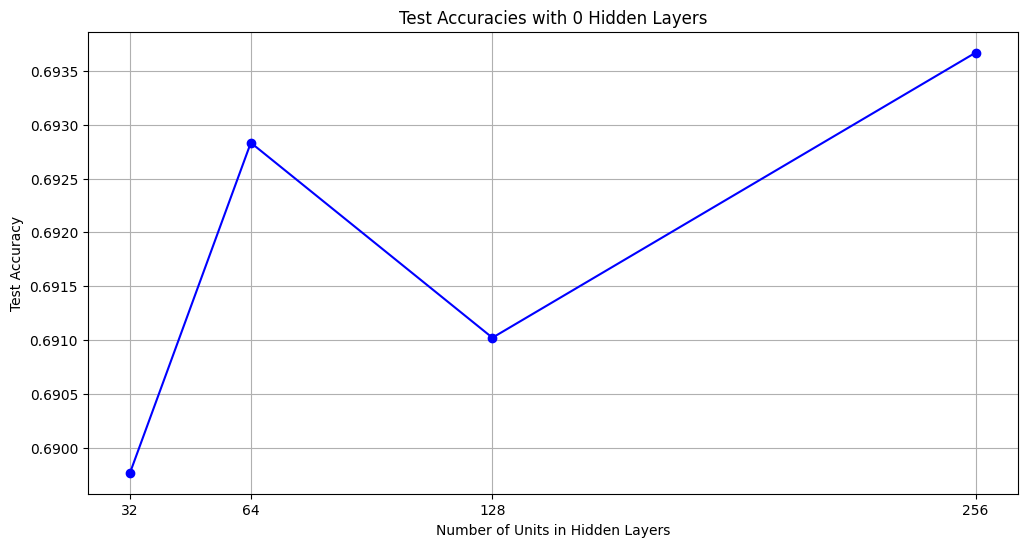


Best model with 0 hidden layers and 256 units: Test accuracy = 0.6937

Training with 1 hidden layers and 32 units...
Epoch 10, Loss: 0.9210, Accuracy: 0.7275
Epoch 20, Loss: 0.5044, Accuracy: 0.8588
Epoch 30, Loss: 0.2850, Accuracy: 0.9290
Epoch 40, Loss: 0.1669, Accuracy: 0.9714
Epoch 50, Loss: 0.1041, Accuracy: 0.9894
Epoch 60, Loss: 0.0711, Accuracy: 0.9952
Epoch 70, Loss: 0.0519, Accuracy: 0.9976
Epoch 80, Loss: 0.0399, Accuracy: 0.9987
Epoch 90, Loss: 0.0319, Accuracy: 0.9995
Epoch 100, Loss: 0.0263, Accuracy: 0.9998
Test accuracy after training with 32 units: 0.6905

Training with 1 hidden layers and 64 units...
Epoch 10, Loss: 0.7444, Accuracy: 0.7908
Epoch 20, Loss: 0.3608, Accuracy: 0.9032
Epoch 30, Loss: 0.1851, Accuracy: 0.9668
Epoch 40, Loss: 0.1027, Accuracy: 0.9922
Epoch 50, Loss: 0.0649, Accuracy: 0.9985
Epoch 60, Loss: 0.0453, Accuracy: 0.9997
Epoch 70, Loss: 0.0340, Accuracy: 1.0000
Epoch 80, Loss: 0.0268, Accuracy: 1.0000
Epoch 90, Loss: 0.0218, Accuracy: 1.0000
Epoc

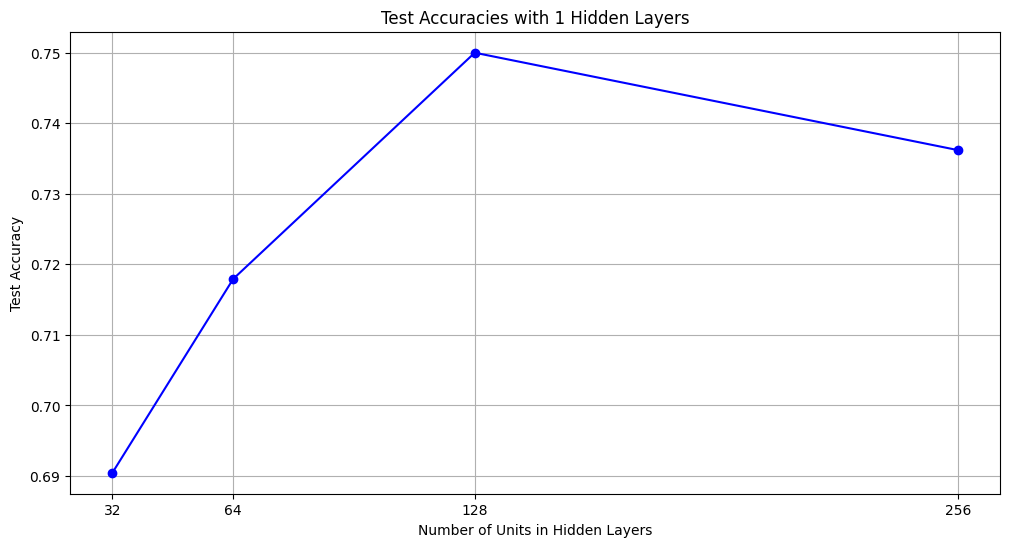


Best model with 1 hidden layers and 128 units: Test accuracy = 0.7500

Training with 2 hidden layers and 32 units...
Epoch 10, Loss: 1.0588, Accuracy: 0.6392
Epoch 20, Loss: 0.4835, Accuracy: 0.8320
Epoch 30, Loss: 0.1963, Accuracy: 0.9390
Epoch 40, Loss: 0.0865, Accuracy: 0.9767
Epoch 50, Loss: 0.0361, Accuracy: 0.9961
Epoch 60, Loss: 0.0185, Accuracy: 0.9994
Epoch 70, Loss: 0.0118, Accuracy: 0.9998
Epoch 80, Loss: 0.0084, Accuracy: 0.9999
Epoch 90, Loss: 0.0064, Accuracy: 1.0000
Epoch 100, Loss: 0.0052, Accuracy: 1.0000
Test accuracy after training with 32 units: 0.6708

Training with 2 hidden layers and 64 units...
Epoch 10, Loss: 0.6112, Accuracy: 0.8014
Epoch 20, Loss: 0.1610, Accuracy: 0.9591
Epoch 30, Loss: 0.0435, Accuracy: 0.9981
Epoch 40, Loss: 0.0195, Accuracy: 0.9998
Epoch 50, Loss: 0.0120, Accuracy: 0.9999
Epoch 60, Loss: 0.0084, Accuracy: 1.0000
Epoch 70, Loss: 0.0064, Accuracy: 1.0000
Epoch 80, Loss: 0.0051, Accuracy: 1.0000
Epoch 90, Loss: 0.0042, Accuracy: 1.0000
Epoc

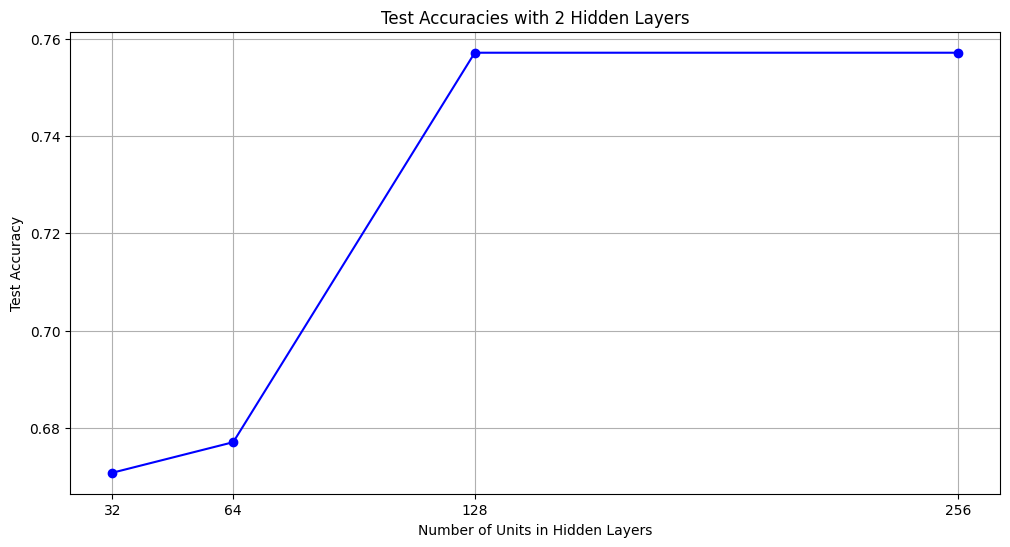


Best model with 2 hidden layers and 128 units: Test accuracy = 0.7571


In [7]:
def evaluate_acc(y_true_one_hot, y_pred_indices):
    y_true_indices = np.argmax(y_true_one_hot, axis=1)
    return np.mean(y_true_indices == y_pred_indices)

def experiment(hidden_layers_count, hidden_units_options, epochs=100, learning_rate=0.01, batch_size=32):
    test_accuracies = []

    for units in hidden_units_options:
        print(f"\nTraining with {hidden_layers_count} hidden layers and {units} units...")
        hidden_dims = [units] * hidden_layers_count

        model = MLP(input_dim=X_train_flattened.shape[1],
                    hidden_dims=hidden_dims,
                    output_dim=num_classes_mapped,
                    use_hidden_layers=hidden_layers_count > 0)
        model.fit(X_train_flattened, y_train_encoded, epochs, learning_rate, batch_size)
        predictions = model.predict(X_test_flattened)
        accuracy = evaluate_acc(y_test_encoded, predictions)
        test_accuracies.append(accuracy)
        print(f"Test accuracy after training with {units} units: {accuracy:.4f}")

    # Plot test accs
    plt.figure(figsize=(12, 6))
    plt.plot(hidden_units_options, test_accuracies, marker='o', linestyle='-', color='b')
    plt.title(f'Test Accuracies with {hidden_layers_count} Hidden Layers')
    plt.xlabel('Number of Units in Hidden Layers')
    plt.ylabel('Test Accuracy')
    plt.xticks(hidden_units_options)
    plt.grid(True)
    plt.show()

    best_units = hidden_units_options[np.argmax(test_accuracies)]
    best_accuracy = max(test_accuracies)
    print(f"\nBest model with {hidden_layers_count} hidden layers and {best_units} units: Test accuracy = {best_accuracy:.4f}")
    return best_units, best_accuracy

configs = [0, 1, 2]  # # of hidden layers
hidden_units_options = [32, 64, 128, 256]

for config in configs:
    _, _ = experiment(config, hidden_units_options)

### 2. Take the last model above, i.e., the one with 2 hidden layers, and create two different copies of it in which the activation functions are now sigmoid and Leaky-ReLU. After trainingnthese two models compare their test accuracies with model having ReLU activations.

In [8]:
class MLP:
    def __init__(self, input_dim, hidden_dims, output_dim, activation='relu'):
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.test_accuracies = []

        activations = {
            'relu': (relu, relu_derivative),
            'sigmoid': (sigmoid, sigmoid_derivative),
            'leaky_relu': (leaky_relu, leaky_relu_derivative),
        }

        self.activation, self.activation_derivative = activations[activation]

        layers = [input_dim] + hidden_dims + [output_dim]
        self.weights = [np.random.randn(prev, next) * 0.1 for prev, next in zip(layers[:-1], layers[1:])]
        self.biases = [np.zeros((1, size)) for size in layers[1:]]

    def forward(self, X):
        self.activations = [X]
        self.Zs = []
        for W, b in zip(self.weights[:-1], self.biases[:-1]):
            Z = np.dot(self.activations[-1], W) + b
            A = self.activation(Z)
            self.Zs.append(Z)
            self.activations.append(A)

        Z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        A = softmax(Z)
        self.Zs.append(Z)
        self.activations.append(A)
        return A

    def backward(self, X, y):
        m = y.shape[0]
        output_error = self.activations[-1] - y
        self.dWs = []
        self.dBs = []

        for i in reversed(range(len(self.weights))):
            dW = np.dot(self.activations[i].T, output_error) / m
            dB = np.sum(output_error, axis=0, keepdims=True) / m
            self.dWs.insert(0, dW)
            self.dBs.insert(0, dB)

            if i > 0:
                output_error = np.dot(output_error, self.weights[i].T) * self.activation_derivative(self.Zs[i-1])

    def update_parameters(self, learning_rate):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * self.dWs[i]
            self.biases[i] -= learning_rate * self.dBs[i]
        self.dWs = []
        self.dBs = []


    def fit(self, X, y, epochs, learning_rate, batch_size):
        self.training_losses = []
        self.training_accuracies = []
        self.test_accuracies = []

        for epoch in range(epochs):
            for i in range(0, X.shape[0], batch_size):
                end = i + batch_size
                batch_X, batch_y = X[i:end], y[i:end]
                self.forward(batch_X)
                self.backward(batch_X, batch_y)
                self.update_parameters(learning_rate)

            loss = compute_loss(y, self.forward(X))
            accuracy = evaluate_acc(y, self.predict(X))
            self.training_losses.append(loss)
            self.training_accuracies.append(accuracy)

            test_predictions = self.predict(X_test)
            test_accuracy = evaluate_acc(y_test_encoded, test_predictions)
            self.test_accuracies.append(test_accuracy)

            if epoch % 10 == 9:
                print(f"Epoch {epoch + 1}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")



    def predict(self, X):
        probabilities = self.forward(X)
        return np.argmax(probabilities, axis=1)

    def check_gradients(self, X, y, epsilon=1e-7, layer_idx=0):
        original_weights = self.weights[layer_idx].copy()
        num_grads = np.zeros_like(original_weights)
        self.forward(X)
        self.backward(X, y)
        analytical_grads = self.dWs[layer_idx]

        for i in range(original_weights.shape[0]):
            for j in range(original_weights.shape[1]):
                self.weights[layer_idx][i, j] += epsilon
                loss_plus_epsilon = compute_loss(y, self.forward(X))
                self.weights[layer_idx][i, j] -= 2 * epsilon
                loss_minus_epsilon = compute_loss(y, self.forward(X))
                self.weights[layer_idx][i, j] = original_weights[i, j]
                num_grads[i, j] = (loss_plus_epsilon - loss_minus_epsilon) / (2 * epsilon)

        self.weights[layer_idx] = original_weights

        numerator = np.linalg.norm(analytical_grads - num_grads)
        denominator = np.linalg.norm(analytical_grads) + np.linalg.norm(num_grads)
        relative_error = numerator / denominator

        print(f"Gradient Check Relative Error for layer {layer_idx}: {relative_error}")
        return relative_error

def plot_accuracies(models, model_names):
    plt.figure(figsize=(12, 6))
    for model, name in zip(models, model_names):
        plt.plot(model.training_accuracies, label=f'{name} Training Accuracy')
        plt.plot(model.test_accuracies, label=f'{name} Test Accuracy')
    plt.title('Model Accuracies Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [9]:
relu_model = MLP(input_dim=X_train_flattened.shape[1], hidden_dims=[64, 64], output_dim=num_classes_mapped, activation='relu')
sigmoid_model = MLP(input_dim=X_train_flattened.shape[1], hidden_dims=[64, 64], output_dim=num_classes_mapped, activation='sigmoid')
leaky_relu_model = MLP(input_dim=X_train_flattened.shape[1], hidden_dims=[64, 64], output_dim=num_classes_mapped, activation='leaky_relu')

# Fit the models
relu_model.fit(X_train_flattened, y_train_encoded, epochs=100, learning_rate=0.01, batch_size=32)
sigmoid_model.fit(X_train_flattened, y_train_encoded, epochs=100, learning_rate=0.01, batch_size=32)
leaky_relu_model.fit(X_train_flattened, y_train_encoded, epochs=100, learning_rate=0.01, batch_size=32)

Epoch 10, Loss: 0.5278, Accuracy: 0.8347
Epoch 20, Loss: 0.1545, Accuracy: 0.9579
Epoch 30, Loss: 0.0366, Accuracy: 0.9984
Epoch 40, Loss: 0.0180, Accuracy: 0.9999
Epoch 50, Loss: 0.0114, Accuracy: 1.0000
Epoch 60, Loss: 0.0080, Accuracy: 1.0000
Epoch 70, Loss: 0.0060, Accuracy: 1.0000
Epoch 80, Loss: 0.0047, Accuracy: 1.0000
Epoch 90, Loss: 0.0039, Accuracy: 1.0000
Epoch 100, Loss: 0.0033, Accuracy: 1.0000


<ipython-input-5-619d81a24be0>:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 10, Loss: 3.0692, Accuracy: 0.1469
Epoch 20, Loss: 2.3183, Accuracy: 0.2986
Epoch 30, Loss: 1.8726, Accuracy: 0.3987
Epoch 40, Loss: 1.5779, Accuracy: 0.5105
Epoch 50, Loss: 1.3056, Accuracy: 0.5867
Epoch 60, Loss: 1.0951, Accuracy: 0.6549
Epoch 70, Loss: 0.9216, Accuracy: 0.7258
Epoch 80, Loss: 0.7761, Accuracy: 0.7773
Epoch 90, Loss: 0.6544, Accuracy: 0.8195
Epoch 100, Loss: 0.5523, Accuracy: 0.8542
Epoch 10, Loss: 0.5820, Accuracy: 0.8132
Epoch 20, Loss: 0.1723, Accuracy: 0.9523
Epoch 30, Loss: 0.0429, Accuracy: 0.9970
Epoch 40, Loss: 0.0197, Accuracy: 0.9996
Epoch 50, Loss: 0.0120, Accuracy: 0.9999
Epoch 60, Loss: 0.0083, Accuracy: 1.0000
Epoch 70, Loss: 0.0062, Accuracy: 1.0000
Epoch 80, Loss: 0.0049, Accuracy: 1.0000
Epoch 90, Loss: 0.0040, Accuracy: 1.0000
Epoch 100, Loss: 0.0033, Accuracy: 1.0000


ReLU Model Test Accuracy: 0.7258784160624652
Sigmoid Model Test Accuracy: 0.5895147796988288
Leaky ReLU Model Test Accuracy: 0.7508365867261573


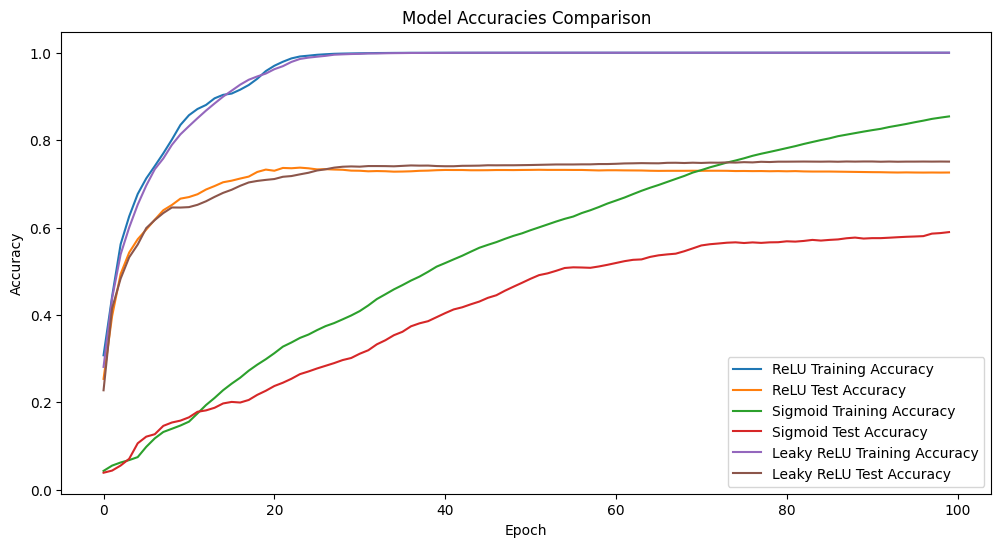

In [10]:
# Compare accuracies and plot
print(f"ReLU Model Test Accuracy: {relu_model.test_accuracies[-1]}")
print(f"Sigmoid Model Test Accuracy: {sigmoid_model.test_accuracies[-1]}")
print(f"Leaky ReLU Model Test Accuracy: {leaky_relu_model.test_accuracies[-1]}")

plot_accuracies([relu_model, sigmoid_model, leaky_relu_model], ["ReLU", "Sigmoid", "Leaky ReLU"])

### 3. Take the last model above, i.e., the one with 2 hidden layers and add L2 regularization(λ||W{ℓ}||22) to the network weights for layers ℓ ∈ {1, 2, o} and train the MLP in this way.

In [11]:
class MLP:
    def __init__(self, input_dim, hidden_dims, output_dim, activation='relu', l2_lambda=0.0):
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.test_accuracies = []

        activations = {
            'relu': (relu, relu_derivative),
            'sigmoid': (sigmoid, sigmoid_derivative),
            'leaky_relu': (leaky_relu, leaky_relu_derivative),
        }

        self.activation_str = activation
        self.activation, self.activation_derivative = activations[activation]


        layers = [input_dim] + hidden_dims + [output_dim]
        self.weights = [np.random.randn(prev, next) * 0.1 for prev, next in zip(layers[:-1], layers[1:])]
        self.biases = [np.zeros((1, size)) for size in layers[1:]]

        self.l2_lambda = l2_lambda  # Hyperparam for L2 reg

    def l2_regularization_loss(self):
        l2_loss = 0.0
        for W in self.weights:
            l2_loss += np.sum(W ** 2)
        l2_loss *= self.l2_lambda / 2
        return l2_loss

    def forward(self, X):
        self.activations = [X]
        self.Zs = []
        for W, b in zip(self.weights[:-1], self.biases[:-1]):
            Z = np.dot(self.activations[-1], W) + b
            A = self.activation(Z)
            self.Zs.append(Z)
            self.activations.append(A)

        Z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        A = softmax(Z)
        self.Zs.append(Z)
        self.activations.append(A)
        return A

    def backward(self, X, y):
        m = y.shape[0]
        output_error = self.activations[-1] - y
        self.dWs = []
        self.dBs = []

        for i in reversed(range(len(self.weights))):
            dW = np.dot(self.activations[i].T, output_error) / m
            dB = np.sum(output_error, axis=0, keepdims=True) / m
            self.dWs.insert(0, dW)
            self.dBs.insert(0, dB)

            if i > 0:
                output_error = np.dot(output_error, self.weights[i].T) * self.activation_derivative(self.Zs[i-1])


    def fit(self, X, y, X_test, y_test, epochs, learning_rate, batch_size):
        self.training_losses = []
        self.training_accuracies = []
        self.test_accuracies = []

        for epoch in range(epochs):
            for i in range(0, X.shape[0], batch_size):
                end = i + batch_size
                batch_X, batch_y = X[i:end], y[i:end]
                self.forward(batch_X)
                self.backward(batch_X, batch_y)
                self.update_parameters(learning_rate)

            loss = compute_loss(y, self.forward(X)) + self.l2_regularization_loss()
            accuracy = evaluate_acc(y, self.predict(X))
            self.training_losses.append(loss)
            self.training_accuracies.append(accuracy)

            test_predictions = self.predict(X_test)
            test_accuracy = evaluate_acc(y_test, test_predictions)
            self.test_accuracies.append(test_accuracy)

            if epoch % 10 == 9:
                print(f"Epoch {epoch + 1}, Loss: {loss:.4f}, Training Accuracy: {accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    def predict(self, X):
        probabilities = self.forward(X)
        return np.argmax(probabilities, axis=1)

    def check_gradients(self, X, y, epsilon=1e-7, layer_idx=0):
        original_weights = self.weights[layer_idx].copy()
        num_grads = np.zeros_like(original_weights)
        self.forward(X)
        self.backward(X, y)
        analytical_grads = self.dWs[layer_idx]

        for i in range(original_weights.shape[0]):
            for j in range(original_weights.shape[1]):
                self.weights[layer_idx][i, j] += epsilon
                loss_plus_epsilon = compute_loss(y, self.forward(X))
                self.weights[layer_idx][i, j] -= 2 * epsilon
                loss_minus_epsilon = compute_loss(y, self.forward(X))
                self.weights[layer_idx][i, j] = original_weights[i, j]
                num_grads[i, j] = (loss_plus_epsilon - loss_minus_epsilon) / (2 * epsilon)

        self.weights[layer_idx] = original_weights

        numerator = np.linalg.norm(analytical_grads - num_grads)
        denominator = np.linalg.norm(analytical_grads) + np.linalg.norm(num_grads)
        relative_error = numerator / denominator

        print(f"Gradient Check Relative Error for layer {layer_idx}: {relative_error}")
        return relative_error


    def update_parameters(self, learning_rate):
        for i in range(len(self.weights)):
            dw = self.dWs[i]
            w = self.weights[i]
            # Update weights with L2 reg term
            self.weights[i] -= learning_rate * (dw + self.l2_lambda * w)
            self.biases[i] -= learning_rate * self.dBs[i]
        self.dWs = []
        self.dBs = []

In [12]:
def fit_and_evaluate(model, X_train, y_train, X_test, y_test, epochs, learning_rate, batch_size, l2_lambda):
    """
    Fits the model, evaluates it at each epoch: prints the loss, training acc, and test acc with the current value of the L2 reg lambda
    """
    model.fit(X_train, y_train, X_test, y_test, epochs, learning_rate, batch_size)
    for epoch in range(epochs):
        if epoch % 10 == 9:
            loss = model.training_losses[epoch]
            training_accuracy = model.training_accuracies[epoch]
            test_accuracy = model.test_accuracies[epoch]
            print(f"L2 λ={l2_lambda:0.4f} - Epoch {epoch + 1:03d}, Loss: {loss:.4f}, Training Acc: {training_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

# Models with different L2 reg lambdas
l2_lambdas = [0.001, 0.01, 0.1]
for l2_lambda in l2_lambdas:
    print(f"Training with L2 regularization λ={l2_lambda}")
    model = MLP(input_dim=X_train_flattened.shape[1], hidden_dims=[64, 64], output_dim=num_classes_mapped, l2_lambda=l2_lambda)
    fit_and_evaluate(model, X_train_flattened, y_train_encoded, X_test_flattened, y_test_encoded, epochs=100, learning_rate=0.01, batch_size=32, l2_lambda=l2_lambda)

Training with L2 regularization λ=0.001
Epoch 10, Loss: 0.9132, Training Accuracy: 0.8159, Test Accuracy: 0.6475
Epoch 20, Loss: 0.5407, Training Accuracy: 0.9501, Test Accuracy: 0.7041
Epoch 30, Loss: 0.4314, Training Accuracy: 0.9831, Test Accuracy: 0.7126
Epoch 40, Loss: 0.3718, Training Accuracy: 0.9974, Test Accuracy: 0.7207
Epoch 50, Loss: 0.3424, Training Accuracy: 0.9994, Test Accuracy: 0.7235
Epoch 60, Loss: 0.3203, Training Accuracy: 0.9997, Test Accuracy: 0.7181
Epoch 70, Loss: 0.3030, Training Accuracy: 0.9997, Test Accuracy: 0.7190
Epoch 80, Loss: 0.2890, Training Accuracy: 0.9998, Test Accuracy: 0.7182
Epoch 90, Loss: 0.2769, Training Accuracy: 0.9998, Test Accuracy: 0.7175
Epoch 100, Loss: 0.2669, Training Accuracy: 0.9998, Test Accuracy: 0.7170
L2 λ=0.0010 - Epoch 010, Loss: 0.9132, Training Acc: 0.8159, Test Acc: 0.6475
L2 λ=0.0010 - Epoch 020, Loss: 0.5407, Training Acc: 0.9501, Test Acc: 0.7041
L2 λ=0.0010 - Epoch 030, Loss: 0.4314, Training Acc: 0.9831, Test Acc: 0.

In [13]:
def plot_accuracies(models, titles, epochs):
    plt.figure(figsize=(14, 7))
    for model, title in zip(models, titles):
        plt.plot(range(1, epochs+1), model.training_accuracies, label=f'{title} Training Accuracy')
        plt.plot(range(1, epochs+1), model.test_accuracies, label=f'{title} Test Accuracy', linestyle='--')

    plt.title('Training and Test Accuracies with L2 Regularization')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch 10, Loss: 0.6240, Training Accuracy: 0.8145, Test Accuracy: 0.6454
Epoch 20, Loss: 0.1965, Training Accuracy: 0.9614, Test Accuracy: 0.6963
Epoch 30, Loss: 0.0908, Training Accuracy: 0.9970, Test Accuracy: 0.7048
Epoch 40, Loss: 0.0681, Training Accuracy: 0.9996, Test Accuracy: 0.7100
Epoch 50, Loss: 0.0612, Training Accuracy: 0.9999, Test Accuracy: 0.7118
Epoch 60, Loss: 0.0579, Training Accuracy: 1.0000, Test Accuracy: 0.7131
Epoch 70, Loss: 0.0560, Training Accuracy: 1.0000, Test Accuracy: 0.7143
Epoch 80, Loss: 0.0546, Training Accuracy: 1.0000, Test Accuracy: 0.7144
Epoch 90, Loss: 0.0536, Training Accuracy: 1.0000, Test Accuracy: 0.7147
Epoch 100, Loss: 0.0529, Training Accuracy: 1.0000, Test Accuracy: 0.7146
Epoch 10, Loss: 0.8785, Training Accuracy: 0.8321, Test Accuracy: 0.6262
Epoch 20, Loss: 0.5168, Training Accuracy: 0.9607, Test Accuracy: 0.6866
Epoch 30, Loss: 0.4126, Training Accuracy: 0.9917, Test Accuracy: 0.7027
Epoch 40, Loss: 0.3654, Training Accuracy: 0.9987,

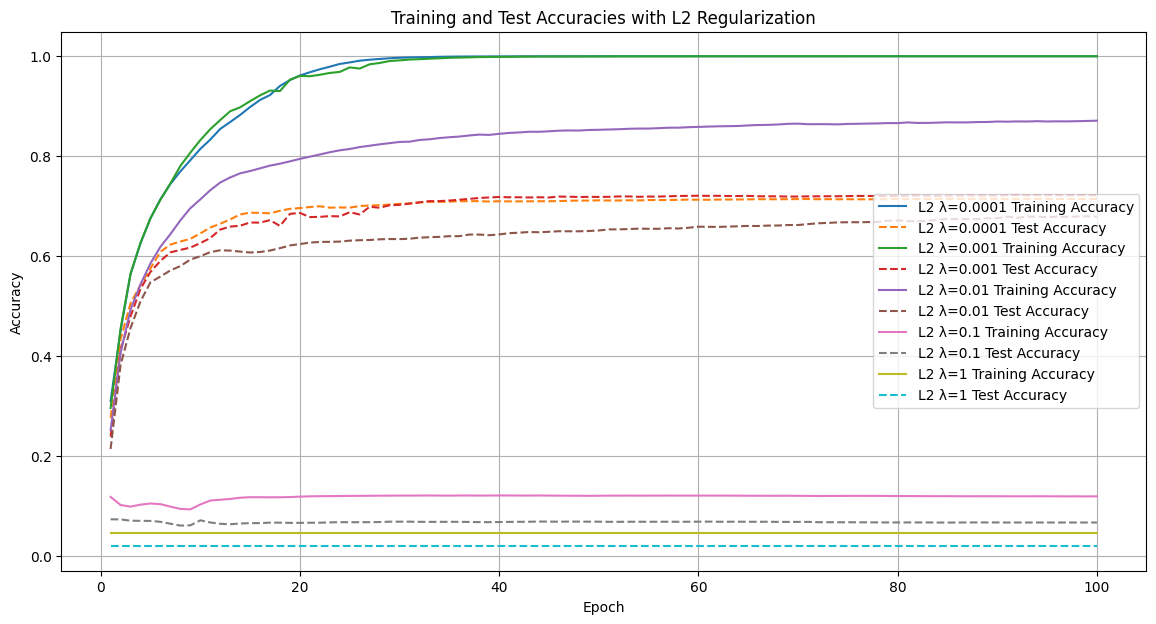

In [14]:
# Experiment with diff values of lambda
l2_lambdas = [0.0001, 0.001, 0.01, 0.1, 1]
models = []
titles = []

for l2_lambda in l2_lambdas:
    model = MLP(input_dim=X_train_flattened.shape[1], hidden_dims=[64, 64], output_dim=num_classes_mapped, l2_lambda=l2_lambda)
    model.fit(X_train_flattened, y_train_encoded, X_test_flattened, y_test_encoded, epochs=100, learning_rate=0.01, batch_size=32)
    models.append(model)
    titles.append(f'L2 λ={l2_lambda}')

plot_accuracies(models, titles, epochs=100)

### 4. Using existing libraries such as Keras/TensorFlow or PyTorch, create a Convolutional Neural Network (ConvNet) with 3 convolutional and 2 fully connected layers

Epoch 1/100
429/429 [==============================] - 31s 69ms/step - loss: 2.0417 - accuracy: 0.3555 - val_loss: 0.9835 - val_accuracy: 0.6840
Epoch 2/100
429/429 [==============================] - 30s 69ms/step - loss: 0.6395 - accuracy: 0.7832 - val_loss: 0.5298 - val_accuracy: 0.8260
Epoch 3/100
429/429 [==============================] - 29s 67ms/step - loss: 0.2980 - accuracy: 0.9009 - val_loss: 0.4421 - val_accuracy: 0.8490
Epoch 4/100
429/429 [==============================] - 29s 67ms/step - loss: 0.1425 - accuracy: 0.9552 - val_loss: 0.4213 - val_accuracy: 0.8674
Epoch 5/100
429/429 [==============================] - 30s 69ms/step - loss: 0.0739 - accuracy: 0.9787 - val_loss: 0.3243 - val_accuracy: 0.9179
Epoch 6/100
429/429 [==============================] - 30s 70ms/step - loss: 0.0473 - accuracy: 0.9868 - val_loss: 0.3220 - val_accuracy: 0.9267
Epoch 7/100
429/429 [==============================] - 31s 71ms/step - loss: 0.0347 - accuracy: 0.9906 - val_loss: 0.3692 - val_ac

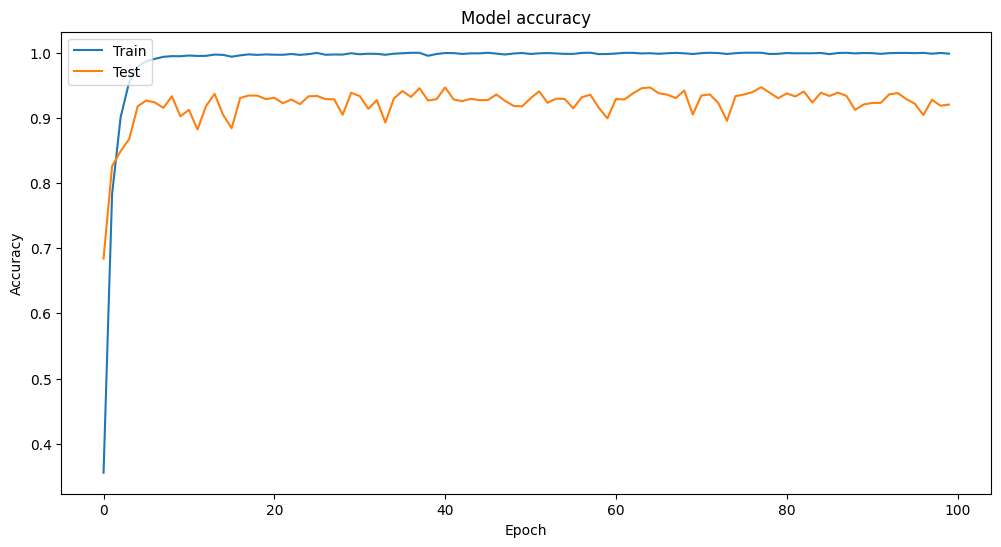

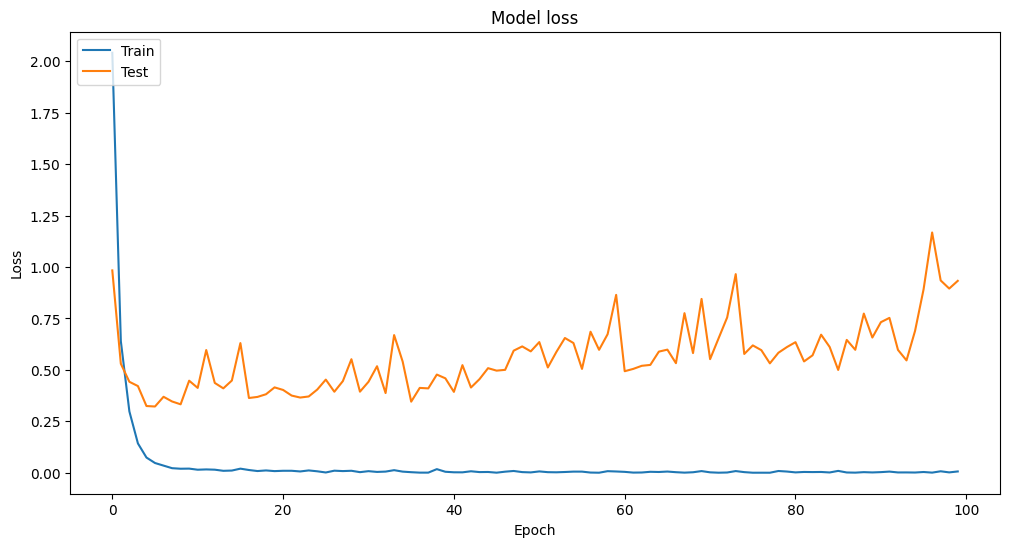

In [15]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

image_height, image_width = 28, 28
num_channels = 1
num_classes = np.unique(y_train).shape[0]

# Normalize/reshape
X_train_normalized = X_train / 255.0
X_test_normalized = X_test / 255.0

X_train_reshaped = X_train_normalized.reshape((-1, image_height, image_width, num_channels))
X_test_reshaped = X_test_normalized.reshape((-1, image_height, image_width, num_channels))

# Find max number of classes
num_classes = max(y_train.max(), y_test.max()) + 1

# one hot encode
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

# Init ConvNet
model = Sequential()

# 1st convolutional layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(image_height, image_width, num_channels)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd convolutional layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd convolutional layer
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten
model.add(Flatten())

# First fully connected layer
model.add(Dense(units=256, activation='relu'))

# dropout for regularization
model.add(Dropout(0.5))

# Second fully connected layer
model.add(Dense(units=num_classes, activation='softmax'))  # Output layer

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train_encoded, epochs=100, batch_size=64, validation_data=(X_test_reshaped, y_test_encoded))

# Training & validation acc
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### 5. Using your MLP implementation, try to come up with an MLP architecture that performs as well as possible.

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Normalize and flatten for MLP and one-hot encode
X_train_normalized = X_train / 255.0
X_test_normalized = X_test / 255.0
X_train_flattened = X_train_normalized.reshape(X_train_normalized.shape[0], -1)
X_test_flattened = X_test_normalized.reshape(X_test_normalized.shape[0], -1)

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

# Model
input_dim = X_train_flattened.shape[1]
num_classes = y_train_encoded.shape[1]
model = Sequential([
    Dense(512, input_dim=input_dim, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training configs
epochs = 100
batch_size = 128
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train
history = model.fit(X_train_flattened, y_train_encoded, epochs=epochs, batch_size=batch_size,
                    validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Evaluate
validation_accuracy = history.history['val_accuracy'][-1]
print(f'Validation Accuracy: {validation_accuracy}')

Epoch 1/100
172/172 [==============================] - 6s 27ms/step - loss: 3.0316 - accuracy: 0.0989 - val_loss: 2.4130 - val_accuracy: 0.2974
Epoch 2/100
172/172 [==============================] - 3s 18ms/step - loss: 2.3411 - accuracy: 0.2381 - val_loss: 1.8282 - val_accuracy: 0.4292
Epoch 3/100
172/172 [==============================] - 3s 19ms/step - loss: 2.0279 - accuracy: 0.3187 - val_loss: 1.5594 - val_accuracy: 0.5141
Epoch 4/100
172/172 [==============================] - 4s 22ms/step - loss: 1.8869 - accuracy: 0.3598 - val_loss: 1.4365 - val_accuracy: 0.5731
Epoch 5/100
172/172 [==============================] - 4s 24ms/step - loss: 1.7617 - accuracy: 0.3988 - val_loss: 1.2667 - val_accuracy: 0.6207
Epoch 6/100
172/172 [==============================] - 3s 18ms/step - loss: 1.6779 - accuracy: 0.4207 - val_loss: 1.1937 - val_accuracy: 0.6390
Epoch 7/100
172/172 [==============================] - 3s 18ms/step - loss: 1.6178 - accuracy: 0.4373 - val_loss: 1.1042 - val_accuracy:

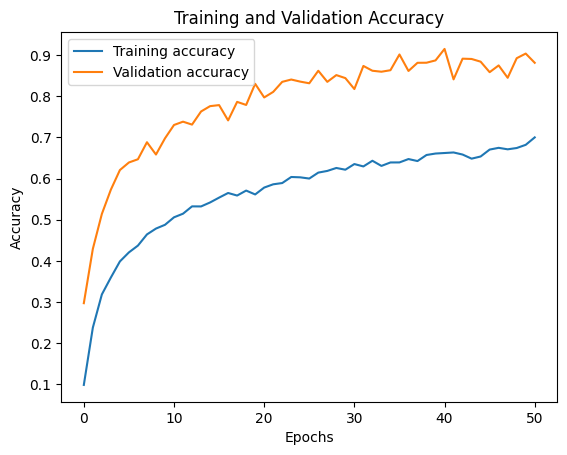

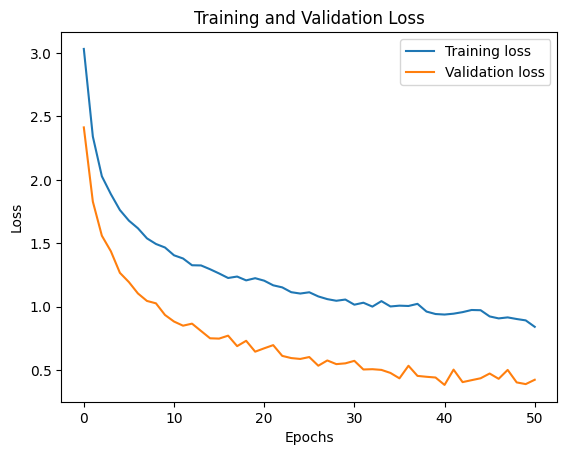

Final Validation Accuracy: 0.8810781240463257


In [17]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(f'Final Validation Accuracy: {validation_accuracy}')

### Experiment with a Subset of the Image Dataset:

Another interesting thing to report might be training the MLP and ConvNet with $10^{k}$, k ∈ {0, 1, 2, 3, 4} images and plotting the test accuracy.

In [18]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train / 255.0
X_test = X_test / 255.0

X_train_reshaped = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], 28, 28, 1))

y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

num_classes = np.max(y_train) + 1

y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

# Define model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit model
history = model.fit(X_train_reshaped[:10000], y_train_encoded[:10000], epochs=5,
                    validation_data=(X_test_reshaped[:2000], y_test_encoded[:2000]), verbose=2)


11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/5
313/313 - 7s - loss: 0.5968 - accuracy: 0.8175 - val_loss: 0.2889 - val_accuracy: 0.9145 - 7s/epoch - 23ms/step
Epoch 2/5
313/313 - 8s - loss: 0.2720 - accuracy: 0.9180 - val_loss: 0.2132 - val_accuracy: 0.9325 - 8s/epoch - 25ms/step
Epoch 3/5
313/313 - 7s - loss: 0.1877 - accuracy: 0.9438 - val_loss: 0.1556 - val_accuracy: 0.9510 - 7s/epoch - 21ms/step
Epoch 4/5
313/313 - 8s - loss: 0.1483 - accuracy: 0.9552 - val_loss: 0.1372 - val_accuracy: 0.9540 - 8s/epoch - 26ms/step
Epoch 5/5
313/313 - 6s - loss: 0.1197 - accuracy: 0.9664 - val_loss: 0.1297 - val_accuracy: 0.9590 - 6s/epoch - 19ms/step


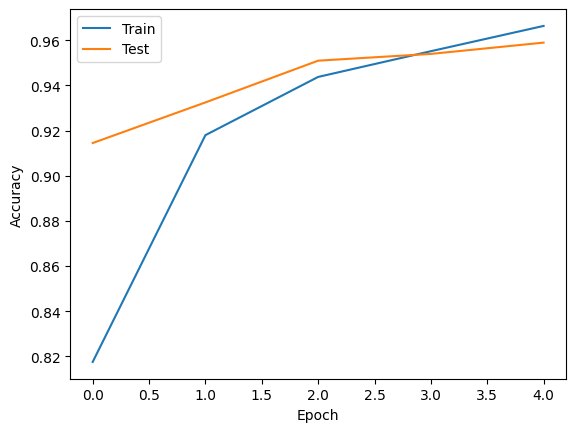

In [19]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### Experiment with different dropout proportions:
Investigate the effect of different dropout rates. Train several models each with a different dropout rate, keeping other parameters constant. This would help to determine the dropout rate that prevents overfitting the most.

[0.2, 0.5, 0.8]

Here, rate = 0.2

In [20]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model

if len(y_train.shape) == 1:
    num_classes = np.max(y_train) + 1
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

num_features = X_train.shape[1]

inputs = Input(shape=(28, 28, 1))
x = Flatten()(inputs)
x = Dense(64, activation='relu')(x)
x = Dropout(rate=0.2)(x)  # Experiment with different dropout rates
x = Dense(64, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

Epoch 1/10
469/469 [==============================] - 4s 6ms/step - loss: 0.4869 - accuracy: 0.8525 - val_loss: 0.1929 - val_accuracy: 0.9415
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2128 - accuracy: 0.9372 - val_loss: 0.1401 - val_accuracy: 0.9578
Epoch 3/10
469/469 [==============================] - 3s 7ms/step - loss: 0.1669 - accuracy: 0.9494 - val_loss: 0.1225 - val_accuracy: 0.9616
Epoch 4/10
469/469 [==============================] - 3s 7ms/step - loss: 0.1448 - accuracy: 0.9553 - val_loss: 0.1062 - val_accuracy: 0.9685
Epoch 5/10
469/469 [==============================] - 3s 6ms/step - loss: 0.1307 - accuracy: 0.9600 - val_loss: 0.0954 - val_accuracy: 0.9715
Epoch 6/10
469/469 [==============================] - 3s 6ms/step - loss: 0.1189 - accuracy: 0.9637 - val_loss: 0.0923 - val_accuracy: 0.9715
Epoch 7/10
469/469 [==============================] - 3s 6ms/step - loss: 0.1094 - accuracy: 0.9663 - val_loss: 0.0880 - val_accuracy: 0.9720
Epoch 

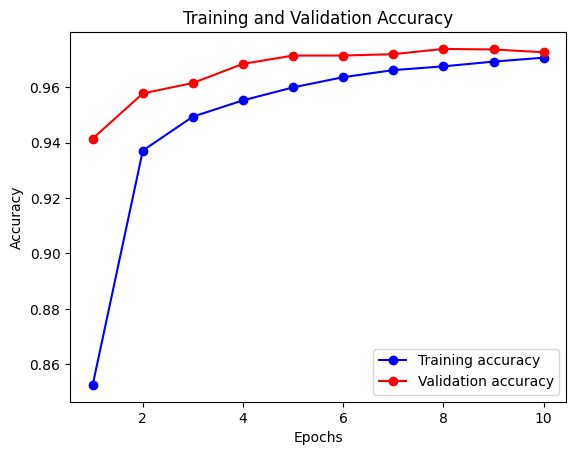

In [21]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_accuracy) + 1)

plt.plot(epochs, training_accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Here, rate = 0.5

In [22]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model

if len(y_train.shape) == 1:
    num_classes = np.max(y_train) + 1
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

num_features = X_train.shape[1]

inputs = Input(shape=(28, 28, 1))
x = Flatten()(inputs)
x = Dense(64, activation='relu')(x)
x = Dropout(rate=0.5)(x)  # Experiment with different dropout rates
x = Dense(64, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)  # Ensure this matches the number of classes

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_accuracy) + 1)

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 0.6512 - accuracy: 0.7991 - val_loss: 0.2476 - val_accuracy: 0.9256
Epoch 2/10
469/469 [==============================] - 3s 7ms/step - loss: 0.3630 - accuracy: 0.8913 - val_loss: 0.1925 - val_accuracy: 0.9415
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.3081 - accuracy: 0.9073 - val_loss: 0.1677 - val_accuracy: 0.9499
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2782 - accuracy: 0.9161 - val_loss: 0.1510 - val_accuracy: 0.9521
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.2596 - accuracy: 0.9205 - val_loss: 0.1395 - val_accuracy: 0.9562
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.2483 - accuracy: 0.9233 - val_loss: 0.1304 - val_accuracy: 0.9599
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.2339 - accuracy: 0.9289 - val_loss: 0.1289 - val_accuracy: 0.9613
Epoch 